In [13]:
import pandas as pd
import os, re, json, shutil, datetime, zipfile
from pathlib import Path
from convokit import Corpus, Speaker, Utterance, Conversation
from collections import Counter
import re

In [14]:
# Load the ConvoKit corpus
corpus = Corpus(filename="./dialog_corpus")
print(f"Number of conversations: {len(list(corpus.iter_conversations()))}")
print(f"Number of utterances: {len(list(corpus.iter_utterances()))}")
print(f"Number of speakers: {len(list(corpus.iter_speakers()))}")

# Show corpus metadata
print("\n=== Corpus Metadata ===")
print(corpus.meta)

Number of conversations: 1300
Number of utterances: 38365
Number of speakers: 2600

=== Corpus Metadata ===
{}


In [15]:
# 随机输出几个conversation和utterance，展示数据结构

import random

# 打印若干 conversation 的结构
print("\n=== Sample Conversations ===")
all_convs = list(corpus.iter_conversations())
sample_convs = random.sample(all_convs, min(3, len(all_convs)))
for conv in sample_convs:
    print(f"Conversation ID: {conv.id}")
    print(f"Meta: {conv.meta}")
    print(f"Number of Utterances: {len(conv.get_utterance_ids())}")
    print("Utterance IDs:", conv.get_utterance_ids()[:3], "...")
    print()

# 打印若干 utterance 的结构
print("\n=== Sample Utterances ===")
all_utts = list(corpus.iter_utterances())
sample_utts = random.sample(all_utts, min(3, len(all_utts)))
for utt in sample_utts:
    print(f"Utterance ID: {utt.id}")
    print(f"Speaker: {utt.speaker.id if utt.speaker else None}")
    print(f"Text: {utt.text[:60]}" + ("..." if len(utt.text) > 60 else ""))
    print(f"Conversation ID: {utt.conversation_id}")
    print(f"Reply to: {utt.reply_to}")
    print(f"Meta: {utt.meta}")
    print()



=== Sample Conversations ===
Conversation ID: conversation_649
Meta: {'experience_type': 'Current Experience', 'emotion_type': 'anxiety', 'problem_type': 'job crisis', 'situation': 'My company laid off 10% of the workforce and another 10% has been furloughed.', 'survey_score': {'seeker': {'initial_emotion_intensity': '5', 'empathy': '4', 'relevance': '4', 'final_emotion_intensity': '3'}, 'supporter': {'relevance': '4'}}, 'seeker_question1': 'It does take some time to get matched up.', 'seeker_question2': 'Have a higher base.', 'supporter_question1': '', 'supporter_question2': ''}
Number of Utterances: 22
Utterance IDs: ['utterance_649_0', 'utterance_649_1', 'utterance_649_2'] ...

Conversation ID: conversation_185
Meta: {'experience_type': 'Current Experience', 'emotion_type': 'sadness', 'problem_type': 'problems with friends', 'situation': 'My cousin is overly sensitive in weird, unpredictable ways.', 'survey_score': {'seeker': {'initial_emotion_intensity': '2', 'empathy': '5', 'rele

In [16]:
import json
import os

# 读取GPT文件夹中的所有json文件，将id中的seeker替换为utterance
sb_data = {}
gpt_dir = "./GPT"

print("正在从GPT文件中读取SB分数...")
for filename in os.listdir(gpt_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(gpt_dir, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            for item in data:
                orig_id = item['id']  # 例如 "seeker_0_2"
                utt_id = orig_id.replace('seeker', 'utterance')
                sb_value = item['SB']
                sb_data[utt_id] = sb_value

print(json.dumps(sb_data, ensure_ascii=False, indent=2))


正在从GPT文件中读取SB分数...
{
  "utterance_729_1": 0.2,
  "utterance_729_3": 0.4,
  "utterance_729_4": 0.5,
  "utterance_729_6": 0.4,
  "utterance_729_8": 0.5,
  "utterance_729_9": 0.6,
  "utterance_729_11": 0.4,
  "utterance_729_13": 0.3,
  "utterance_729_16": 0.5,
  "utterance_729_17": 0.6,
  "utterance_729_18": 0.6,
  "utterance_729_22": 0.7,
  "utterance_729_24": 0.2,
  "utterance_729_28": 0.5,
  "utterance_729_29": 0.6,
  "utterance_729_31": 0.5,
  "utterance_729_33": 0.7,
  "utterance_729_35": 0.4,
  "utterance_729_37": 0.8,
  "utterance_729_38": 0.4,
  "utterance_683_1": 0.0,
  "utterance_683_3": 0.3,
  "utterance_683_5": 0.0,
  "utterance_683_7": 0.6,
  "utterance_683_9": 0.0,
  "utterance_683_11": 0.7,
  "utterance_683_13": 0.4,
  "utterance_683_15": 0.3,
  "utterance_683_17": 0.0,
  "utterance_683_19": 0.6,
  "utterance_379_1": 0.3,
  "utterance_379_3": 0.0,
  "utterance_379_6": 0.5,
  "utterance_379_8": 0.4,
  "utterance_379_10": 0.6,
  "utterance_379_12": 0.3,
  "utterance_379_14": 

In [18]:
import os
import json

gpt_dir = "./GPT"
file_count = 0
total_item_count = 0
file_item_counts = {}

for filename in os.listdir(gpt_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(gpt_dir, filename)
        file_count += 1
        with open(filepath, "r") as f:
            try:
                data = json.load(f)
                item_count = len(data)
                file_item_counts[filename] = item_count
                total_item_count += item_count
            except Exception as e:
                print(f"Error loading {filename}: {e}")

print(f"GPT文件夹中共有 {file_count} 个json文件")
for fname, cnt in file_item_counts.items():
    print(f"{fname} 里共有 {cnt} 个 (seeker_x_y)")
print(f"所有json的len加起来一共: {total_item_count}")


GPT文件夹中共有 1299 个json文件
729.json 里共有 20 个 (seeker_x_y)
683.json 里共有 10 个 (seeker_x_y)
379.json 里共有 8 个 (seeker_x_y)
396.json 里共有 9 个 (seeker_x_y)
1209.json 里共有 9 个 (seeker_x_y)
816.json 里共有 18 个 (seeker_x_y)
115.json 里共有 10 个 (seeker_x_y)
1120.json 里共有 9 个 (seeker_x_y)
545.json 里共有 11 个 (seeker_x_y)
1065.json 里共有 36 个 (seeker_x_y)
400.json 里共有 16 个 (seeker_x_y)
953.json 里共有 12 个 (seeker_x_y)
284.json 里共有 8 个 (seeker_x_y)
791.json 里共有 8 个 (seeker_x_y)
512.json 里共有 8 个 (seeker_x_y)
1177.json 里共有 12 个 (seeker_x_y)
142.json 里共有 8 个 (seeker_x_y)
841.json 里共有 9 个 (seeker_x_y)
904.json 里共有 12 个 (seeker_x_y)
1198.json 里共有 11 个 (seeker_x_y)
457.json 里共有 10 个 (seeker_x_y)
1032.json 里共有 8 个 (seeker_x_y)
292.json 里共有 14 个 (seeker_x_y)
768.json 里共有 19 个 (seeker_x_y)
338.json 里共有 11 个 (seeker_x_y)
787.json 里共有 11 个 (seeker_x_y)
1248.json 里共有 9 个 (seeker_x_y)
857.json 里共有 10 个 (seeker_x_y)
154.json 里共有 13 个 (seeker_x_y)
1161.json 里共有 18 个 (seeker_x_y)
504.json 里共有 12 个 (seeker_x_y)
1024.json 里共有 6 个 (

In [8]:
# Read intent data from utterances_intent.jsonl
intent_data = {}

print("Loading intent data from utterances_intent.jsonl...")
with open('./utterances_intent.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line.strip())
        utterance_id = data['id']
        intent_data[utterance_id] = {
            'intent': data['intent'],
            'intent_confidence': data['confidence']
        }

print(f"Loaded intent data for {len(intent_data)} utterances")
print(f"Sample intent data: {list(intent_data.items())[:1]}")


Loading intent data from utterances_intent.jsonl...
Loaded intent data for 19989 utterances
Sample intent data: [('utterance_0_0', {'intent': 'Social Talk', 'intent_confidence': 0.9})]


In [ ]:
print(f"Number of SB data entries: {len(sb_data)}")
print(f"Number of intent data entries: {len(intent_data)}")
if len(sb_data) == len(intent_data):
    print("sb_data and intent_data have the same number of entries.")
else:
    print("sb_data and intent_data have DIFFERENT number of entries.")


Number of SB data entries: 15539
Number of intent data entries: 19989
sb_data and intent_data have DIFFERENT number of entries.


In [ ]:
# 检查 sb_data 和 intent_data 的 key（utterance_id）为什么会不一样
from collections import defaultdict

# 获取二者的key集合
sb_keys = set(sb_data.keys())
intent_keys = set(intent_data.keys())

# 分别在sb_data但不在intent_data中的utterance_id，及反之
sb_only = sb_keys - intent_keys
intent_only = intent_keys - sb_keys

print(f"sb_data中有但intent_data没有的utterance_id数量: {len(sb_only)}")
if sb_only:
    print(f"例子（最多前10个）: {list(sb_only)[:10]}")
print(f"intent_data中有但sb_data没有的utterance_id数量: {len(intent_only)}")
if intent_only:
    print(f"例子（最多前10个）: {list(intent_only)[:10]}")

# 分析id后缀，conversation_id和local_utt_id
def analyze_ids(id_set, label):
    conv2utts = defaultdict(list)
    for uid in id_set:
        try:
            parts = uid.split('_')
            conv = parts[1]
            local = int(parts[2])
            conv2utts[conv].append(local)
        except Exception as e:
            print(f"{label}: 无法解析utterance_id: {uid}，错误信息: {e}")
    # 分析conversation内的utterance local id是否有跳号现象
    summary = {}
    for conv, utt_ids in conv2utts.items():
        sorted_ids = sorted(utt_ids)
        missing = []
        if sorted_ids:
            for i in range(sorted_ids[0], sorted_ids[-1]):
                if i not in utt_ids:
                    missing.append(i)
        if missing:
            summary[conv] = missing
    print(f"{label} 中 conversation范围内local_utt_id跳号的情况（只显示有跳号的）：")
    if summary:
        for conv, missing in list(summary.items())[:5]:  # 最多显示前5个
            print(f"  conversation {conv} 缺失的local_utt_id: {missing}")
    else:
        print("  没有发现明显跳号。")

print("==== 对 sb_data 的 key（utterance_id）分析 ====")
analyze_ids(sb_keys, "sb_data")
print("==== 对 intent_data 的 key（utterance_id）分析 ====")
analyze_ids(intent_keys, "intent_data")

# 比较sb_only和intent_only的分布，看是否局部某些conversation被完全跳过
def count_conversation(ids):
    counts = defaultdict(int)
    for uid in ids:
        try:
            parts = uid.split('_')
            conv = parts[1]
            counts[conv] += 1
        except Exception:
            continue
    return counts

print("\nsb_data only中各conversation分布: (最多显示前10条)")
for conv,count in list(count_conversation(sb_only).items())[:10]:
    print(f"  conversation {conv} : {count}条 utterance")

print("\nintent_data only中各conversation分布: (最多显示前10条)")
for conv,count in list(count_conversation(intent_only).items())[:10]:
    print(f"  conversation {conv} : {count}条 utterance")



sb_data中有但intent_data没有的utterance_id数量: 94
例子（最多前10个）: ['utterance_707_16', 'utterance_255_7', 'utterance_104_16', 'utterance_962_12', 'utterance_933_1', 'utterance_680_17', 'utterance_1021_25', 'utterance_933_20', 'utterance_470_52', 'utterance_229_19']
intent_data中有但sb_data没有的utterance_id数量: 4544
例子（最多前10个）: ['utterance_946_23', 'utterance_929_8', 'utterance_563_28', 'utterance_388_24', 'utterance_556_0', 'utterance_619_0', 'utterance_405_0', 'utterance_583_17', 'utterance_142_0', 'utterance_64_13']
==== 对 sb_data 的 key（utterance_id）分析 ====
sb_data 中 conversation范围内local_utt_id跳号的情况（只显示有跳号的）：
  conversation 1071 缺失的local_utt_id: [4, 9, 11, 13, 15, 17, 19, 22, 24]
  conversation 158 缺失的local_utt_id: [5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 30, 32, 33, 34, 35, 38, 40, 41, 42, 43, 44]
  conversation 476 缺失的local_utt_id: [1, 3, 9, 12, 15, 17, 19, 22]
  conversation 21 缺失的local_utt_id: [3, 5, 7, 9, 11, 13, 15, 17, 19]
  conversation 406 缺失的local_utt_id: [3,

In [25]:
sb_data['utterance_0_18']

0.8

In [26]:
# 将 SB 连续值映射为二元标签（阈值0.7）
sb_binary = {}
for k, v in sb_data.items():
    try:
        sb_binary[k] = 1 if v >= 0.7 else 0
    except Exception:
        sb_binary[k] = None


In [36]:
sb_binary['utterance_0_8']

1

In [38]:
len(sb_binary)

15539

In [40]:
# 只保留 sb_binary 和 intent_data 都有的 id，并整合
# 每个ID配三个标签：intent, intent_confidence, sb_binary

# 只取 sb_binary 和 intent_data 都有的 id（交集）
common_ids = set(sb_binary.keys()) & set(intent_data.keys())
print(f"sb_binary和intent_data都有的ID数量: {len(common_ids)}")

integrated_labels = {}
for uid in common_ids:
    # sb_binary的值已经是0或1
    sb_val = sb_binary.get(uid)
    intent_info = intent_data.get(uid)
    
    if sb_val is not None and intent_info is not None:
        intent_val = intent_info.get("intent")
        confidence_val = intent_info.get("intent_confidence")  # 注意：key是'intent_confidence'不是'confidence'
        
        if intent_val is not None and confidence_val is not None:
            integrated_labels[uid] = {
                "utterance_id": uid,
                "intent": intent_val,
                "intent_confidence": confidence_val,
                "sb_binary": sb_val
            }

print(f"\n成功整合的数据条数: {len(integrated_labels)}")

# 显示前几条示例
if integrated_labels:
    print("\n前5条示例数据:")
    for i, (uid, data) in enumerate(list(integrated_labels.items())[:5]):
        print(f"{i+1}. {data}")
else:
    print("没有找到sb_binary和intent_data都存在的utterance_id")


sb_binary和intent_data都有的ID数量: 15445

成功整合的数据条数: 15445

前5条示例数据:
1. {'utterance_id': 'utterance_1071_5', 'intent': 'Self-Disclosure', 'intent_confidence': 0.9, 'sb_binary': 0}
2. {'utterance_id': 'utterance_476_11', 'intent': 'Advice Seeking', 'intent_confidence': 0.9, 'sb_binary': 0}
3. {'utterance_id': 'utterance_406_22', 'intent': 'Gratitude', 'intent_confidence': 0.9, 'sb_binary': 0}
4. {'utterance_id': 'utterance_158_39', 'intent': 'Self-Disclosure', 'intent_confidence': 0.9, 'sb_binary': 0}
5. {'utterance_id': 'utterance_21_2', 'intent': 'Emotional Expression', 'intent_confidence': 0.9, 'sb_binary': 0}


In [41]:
# 将 integrated_labels 转为 DataFrame，转存 ID 拆分
import pandas as pd

# integrated_labels 转 DataFrame 并按示例方式拆分 conversation_id, turn_id
df = pd.DataFrame(list(integrated_labels.values()))

# 新增 conversation_id 和 turn_id 字段（根据 utterance_id 格式 "utterance_{conv_id}_{turn_id}" 拆分）
ids = df["utterance_id"].str.extract(r"utterance_(\d+)_(\d+)")
df["conv_id"] = ids[0].astype(int)
df["turn_id"] = ids[1].astype(int)

# 若要查看前几行
df.head()


,utterance_id,intent,intent_confidence,sb_binary,conv_id,turn_id
0,utterance_1071_5,Self-Disclosure,0.9,0,1071,5
1,utterance_476_11,Advice Seeking,0.9,0,476,11
2,utterance_406_22,Gratitude,0.9,0,406,22
3,utterance_158_39,Self-Disclosure,0.9,0,158,39
4,utterance_21_2,Emotional Expression,0.9,0,21,2


In [42]:
df.shape

(15445, 6)

In [43]:
# intent 编码为整数，再做 one-hot
intent2id = {intent: i for i, intent in enumerate(sorted(df["intent"].unique()))}
df["intent_id"] = df["intent"].map(intent2id)

num_intents = len(intent2id)
print("Num intents:", num_intents)

# 只保留我们需要的列
df = df[["utterance_id", "conv_id", "turn_id", "intent_id",
         "intent_confidence", "sb_binary"]]

# 按对话和顺序排序
df = df.sort_values(["conv_id", "turn_id"]).reset_index(drop=True)

Num intents: 11


In [45]:
df.head(20)

,utterance_id,conv_id,turn_id,intent_id,intent_confidence,sb_binary
0,utterance_0_2,0,2,4,0.9,0
1,utterance_0_4,0,4,7,0.9,0
2,utterance_0_6,0,6,7,0.9,0
3,utterance_0_8,0,8,8,0.9,1
4,utterance_0_11,0,11,9,0.9,0
5,utterance_0_13,0,13,8,0.9,0
6,utterance_0_15,0,15,8,0.9,0
7,utterance_0_18,0,18,8,0.9,1
8,utterance_0_20,0,20,8,0.9,0
9,utterance_0_21,0,21,5,1.0,0


In [46]:
from sklearn.model_selection import train_test_split

# 获取所有 conversation ID
all_convs = df["conv_id"].unique()

# 按 conversation 切分
train_convs, test_convs = train_test_split(all_convs, test_size=0.2, random_state=42)
train_convs, val_convs = train_test_split(train_convs, test_size=0.1, random_state=42)

train_df = df[df["conv_id"].isin(train_convs)]
val_df = df[df["conv_id"].isin(val_convs)]
test_df = df[df["conv_id"].isin(test_convs)]

len(train_df), len(val_df), len(test_df)


(11226, 1199, 3020)

In [47]:
def show_balance(name, df):
    print(f"=== {name} ===")
    print(df["sb_binary"].value_counts())
    print(df["sb_binary"].value_counts(normalize=True))

show_balance("TRAIN", train_df)
show_balance("VAL", val_df)
show_balance("TEST", test_df)


=== TRAIN ===
sb_binary
0    8721
1    2505
Name: count, dtype: int64
sb_binary
0    0.776857
1    0.223143
Name: proportion, dtype: float64
=== VAL ===
sb_binary
0    937
1    262
Name: count, dtype: int64
sb_binary
0    0.781485
1    0.218515
Name: proportion, dtype: float64
=== TEST ===
sb_binary
0    2310
1     710
Name: count, dtype: int64
sb_binary
0    0.764901
1    0.235099
Name: proportion, dtype: float64


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# ===== 1. 选择 baseline 的输入特征 =====
baseline_features = ["intent_id", "intent_confidence", "turn_id"]  # 如果你有 turn_id_norm，就改成它

X_train = train_df[baseline_features].values
X_val   = val_df[baseline_features].values
X_test  = test_df[baseline_features].values

y_train = train_df["sb_binary"].values
y_val   = val_df["sb_binary"].values
y_test  = test_df["sb_binary"].values

# ===== 2. 特征标准化（尤其是 turn_id）=====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ===== 3. 定义 Logistic Regression，解决类不平衡 =====
clf = LogisticRegression(
    class_weight="balanced",  # 自动给少数类（SB=1）更大权重
    max_iter=500,
    solver="lbfgs"
)

# ===== 4. 训练 =====
clf.fit(X_train, y_train)

baseline_results = {}

# ===== 5. 在 train / val / test 上评估 =====
def eval_split(X, y, name):
    y_pred = clf.predict(X)
    print(f"\n=== {name} ===")
    print(classification_report(y, y_pred, digits=3))
    acc = accuracy_score(y, y_pred)
    macro = f1_score(y, y_pred, average="macro")
    pos_f1 = f1_score(y, y_pred, pos_label=1)
    print("Accuracy:", acc)
    print("Macro F1:", macro)
    print("Pos-class (SB=1) F1:", pos_f1)

    baseline_results[name] = {
        "accuracy": acc,
        "macro_f1": macro,
        "pos_f1": pos_f1,
    }
    return baseline_results[name]

eval_split(X_train, y_train, "TRAIN")
eval_split(X_val, y_val, "VAL")
# 先跑分
test_metrics = eval_split(X_test, y_test, "TEST")

# 把结果变成表格
import pandas as pd
result_table = pd.DataFrame([
    {
        "split": "train",
        **baseline_results["TRAIN"]
    },
    {
        "split": "val",
        **baseline_results["VAL"]
    },
    {
        "split": "test",
        **baseline_results["TEST"]
    }
])

print("\nBaseline results table:")
display(result_table)



=== TRAIN ===
              precision    recall  f1-score   support

           0      0.834     0.601     0.699      8721
           1      0.296     0.583     0.392      2505

    accuracy                          0.597     11226
   macro avg      0.565     0.592     0.545     11226
weighted avg      0.714     0.597     0.630     11226

Accuracy: 0.5970069481560663
Macro F1: 0.5454114961005214
Pos-class (SB=1) F1: 0.3922622246104245

=== VAL ===
              precision    recall  f1-score   support

           0      0.833     0.618     0.710       937
           1      0.290     0.557     0.381       262

    accuracy                          0.605      1199
   macro avg      0.561     0.588     0.545      1199
weighted avg      0.714     0.605     0.638      1199

Accuracy: 0.6046705587989991
Macro F1: 0.5453799339579174
Pos-class (SB=1) F1: 0.381201044386423

=== TEST ===
              precision    recall  f1-score   support

           0      0.826     0.618     0.707      2310


,split,accuracy,macro_f1,pos_f1
0,train,0.597007,0.545411,0.392262
1,val,0.604671,0.545380,0.381201
2,test,0.608278,0.557951,0.408796


In [57]:
import copy
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, accuracy_score

# ---------- 先确保 turn_id_norm 存在 ----------
for split_df in [train_df, val_df, test_df]:
    split_df["turn_id_norm"] = split_df.groupby("conv_id")["turn_id"].transform(
        lambda x: x / x.max() if x.max() > 0 else 0
    )

# 所有 intent 的范围
num_intents = int(max(
    train_df["intent_id"].max(),
    val_df["intent_id"].max(),
    test_df["intent_id"].max()
)) + 1
print("num_intents:", num_intents)


def one_hot_intent(intent_ids, num_intents):
    """intent_ids: 1D array of ints -> 2D one-hot matrix"""
    N = len(intent_ids)
    oh = np.zeros((N, num_intents), dtype=np.float32)
    oh[np.arange(N), intent_ids.astype(int)] = 1.0
    return oh


def build_sequence_data(split_df, K=5):
    """
    对一个 split（train/val/test）构造：
      X: (num_samples, seq_len=K+1, feature_dim)
      y: (num_samples,)
    
    每个 timestep 特征：
      [ sb_binary, intent_onehot..., intent_confidence, turn_id_norm ]
    对于当前句 t：
      sb_binary_t 用 0 占位（不泄露 label）
    history 不足 K 条时，左侧 zero padding。
    """
    all_X = []
    all_y = []

    # 按 conv 分组
    for conv_id, g in split_df.groupby("conv_id"):
        g = g.sort_values("turn_id").reset_index(drop=True)

        intents = g["intent_id"].values
        confs = g["intent_confidence"].values.astype(np.float32)
        sbs    = g["sb_binary"].values.astype(np.float32)
        pos    = g["turn_id_norm"].values.astype(np.float32)

        # 先算每个 time step 的 one-hot
        intents_oh = one_hot_intent(intents, num_intents)  # (N, num_intents)

        N = len(g)
        for t in range(N):
            # 当前句的 label
            y_t = sbs[t]

            # 取历史窗口 [t-K, ..., t]
            start = max(0, t - K)
            end = t  # t 本身作为当前句，我们单独处理

            # 历史部分的索引: start..t-1
            hist_idx = list(range(start, t))  # 可能为空

            hist_feats = []
            for idx in hist_idx:
                feat = np.concatenate([
                    np.array([sbs[idx]]),          # 历史 SB
                    intents_oh[idx],               # intent one-hot
                    np.array([confs[idx]]),
                    np.array([pos[idx]]),
                ], axis=0)
                hist_feats.append(feat)

            # 当前句特征（注意：不放 sb_binary_t）
            curr_feat = np.concatenate([
                np.array([0.0]),                  # 当前句 sb 设为0占位
                intents_oh[t],
                np.array([confs[t]]),
                np.array([pos[t]]),
            ], axis=0)

            # 把历史 + 当前拼成序列，长度 <= K+1
            seq_feats = hist_feats + [curr_feat]  # 长度 = len(hist_idx) + 1

            # 左侧 padding 到固定长度 K+1
            feat_dim = curr_feat.shape[0]
            pad_len = (K + 1) - len(seq_feats)
            if pad_len > 0:
                pad = [np.zeros(feat_dim, dtype=np.float32) for _ in range(pad_len)]
                seq_feats = pad + seq_feats

            X_t = np.stack(seq_feats, axis=0)  # (K+1, feat_dim)
            all_X.append(X_t)
            all_y.append(y_t)

    X = np.stack(all_X, axis=0).astype(np.float32)  # (num_samples, K+1, feat_dim)
    y = np.array(all_y).astype(np.float32)          # (num_samples,)

    print("build_sequence_data: X.shape =", X.shape, " y.mean(SB=1 rate) =", y.mean())
    return X, y





num_intents: 11


/var/folders/zt/8snkcr615md4x5whymf2jvcw0000gn/T/ipykernel_18813/3134062509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["turn_id_norm"] = split_df.groupby("conv_id")["turn_id"].transform(


In [128]:
K = 0  # 使用过去5轮+当前轮作为上下文
X_train, y_train = build_sequence_data(train_df, K=K)
X_val,   y_val   = build_sequence_data(val_df,   K=K)
X_test,  y_test  = build_sequence_data(test_df,  K=K)

seq_len = X_train.shape[1]
feat_dim = X_train.shape[2]
print("seq_len =", seq_len, " feat_dim =", feat_dim)

build_sequence_data: X.shape = (11226, 1, 14)  y.mean(SB=1 rate) = 0.2231427
build_sequence_data: X.shape = (1199, 1, 14)  y.mean(SB=1 rate) = 0.21851543
build_sequence_data: X.shape = (3020, 1, 14)  y.mean(SB=1 rate) = 0.23509933
seq_len = 1  feat_dim = 14


In [130]:
class SBSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 64  # 可以改小/大一点

train_loader = DataLoader(SBSeqDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(SBSeqDataset(X_val,   y_val),   batch_size=batch_size)
test_loader  = DataLoader(SBSeqDataset(X_test,  y_test),  batch_size=batch_size)


In [131]:
class GRUSBModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, 1)  # 输出一个 logit，BCE with logits

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        _, h_n = self.gru(x)       # h_n: (num_layers, batch, hidden_dim)
        h_last = h_n[-1]           # (batch, hidden_dim)
        logit = self.fc(h_last)    # (batch, 1)
        return logit.squeeze(-1)   # (batch,)


In [132]:
# 计算 pos_weight = (#neg / #pos)
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)
print("num_pos:", num_pos, " num_neg:", num_neg, " pos_weight:", pos_weight.item())

device = torch.device("cpu")  # 你可以改成 "cuda" 如果有GPU
model = GRUSBModel(input_dim=feat_dim, hidden_dim=32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_pos: 2505  num_neg: 8721  pos_weight: 3.4814372062683105


In [133]:
def eval_model(model, data_loader, device, split_name="VAL", threshold=0.7):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            probs = torch.sigmoid(logits)

            all_labels.append(y_batch.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)
    all_preds  = (all_probs >= threshold).astype(int)

    acc = accuracy_score(all_labels, all_preds)
    macro = f1_score(all_labels, all_preds, average="macro")
    pos_f1 = f1_score(all_labels, all_preds, pos_label=1)

    print(f"\n=== {split_name} ===")
    print(classification_report(all_labels, all_preds, digits=3))
    print("Accuracy:", acc)
    print("Macro F1:", macro)
    print("Pos-class (SB=1) F1:", pos_f1)

    metrics = {
        "accuracy": acc,
        "macro_f1": macro,
        "pos_f1": pos_f1,
    }
    return all_labels, all_probs, all_preds, metrics


num_epochs = 10  # 可以先试10轮，不够再加

best_macro_f1 = 0.0
best_epoch = 0
best_model_state = None
best_val_metrics = None
training_history = []
best_model_path = f"best_grusb_model_K{K}.pth"

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")

    # 每轮在 VAL 上看一眼
    _, _, _, val_metrics = eval_model(model, val_loader, device, split_name="VAL")

    training_history.append({
        "epoch": epoch,
        "train_loss": avg_loss,
        "val_accuracy": val_metrics["accuracy"],
        "val_macro_f1": val_metrics["macro_f1"],
        "val_pos_f1": val_metrics["pos_f1"],
    })

    if val_metrics["macro_f1"] > best_macro_f1:
        best_macro_f1 = val_metrics["macro_f1"]
        best_epoch = epoch
        best_model_state = copy.deepcopy(model.state_dict())
        best_val_metrics = val_metrics.copy()
        print(f"[BEST] Saved best model at epoch {epoch} (macro F1={best_macro_f1:.4f})")

# 训练结束后保存best model到一个文件
if best_model_state is not None:
    torch.save(best_model_state, best_model_path)
    model.load_state_dict(best_model_state)
    print(
        f"Best model saved from epoch {best_epoch} with macro F1={best_macro_f1:.4f} to '{best_model_path}'"
    )
else:
    print("Warning: best model state was not set; using final epoch weights.")


Epoch 1/10 - Train Loss: 1.0352

=== VAL ===
              precision    recall  f1-score   support

         0.0      0.781     1.000     0.877       937
         1.0      0.000     0.000     0.000       262

    accuracy                          0.781      1199
   macro avg      0.391     0.500     0.439      1199
weighted avg      0.611     0.781     0.686      1199

Accuracy: 0.7814845704753962
Macro F1: 0.4386704119850187
Pos-class (SB=1) F1: 0.0
[BEST] Saved best model at epoch 1 (macro F1=0.4387)


/Users/byc324/Desktop/24Fall/25Fall/communication/assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/byc324/Desktop/24Fall/25Fall/communication/assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/byc324/Desktop/24Fall/25Fall/communication/assignment1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

Epoch 2/10 - Train Loss: 0.9519

=== VAL ===
              precision    recall  f1-score   support

         0.0      0.826     0.879     0.852       937
         1.0      0.438     0.336     0.380       262

    accuracy                          0.761      1199
   macro avg      0.632     0.608     0.616      1199
weighted avg      0.741     0.761     0.749      1199

Accuracy: 0.7606338615512928
Macro F1: 0.6159045880980685
Pos-class (SB=1) F1: 0.3801295896328294
[BEST] Saved best model at epoch 2 (macro F1=0.6159)
Epoch 3/10 - Train Loss: 0.9312

=== VAL ===
              precision    recall  f1-score   support

         0.0      0.818     0.892     0.853       937
         1.0      0.429     0.290     0.346       262

    accuracy                          0.761      1199
   macro avg      0.624     0.591     0.600      1199
weighted avg      0.733     0.761     0.743      1199

Accuracy: 0.7606338615512928
Macro F1: 0.5998690699196861
Pos-class (SB=1) F1: 0.3462414578587699
Epoch 4

Training history saved to final_project_data/training_history_K0.csv


,epoch,train_loss,val_accuracy,val_macro_f1,val_pos_f1
0,1,1.035235,0.781485,0.438670,0.000000
1,2,0.951920,0.760634,0.615905,0.380130
2,3,0.931231,0.760634,0.599869,0.346241
3,4,0.925996,0.754796,0.599239,0.349558
4,5,0.923912,0.754796,0.619478,0.392562
5,6,0.923469,0.754796,0.629640,0.414343
6,7,0.922888,0.763970,0.613577,0.372506
7,8,0.923007,0.753128,0.621537,0.398374
8,9,0.923323,0.755630,0.616610,0.385744
9,10,0.921784,0.762302,0.617322,0.381779


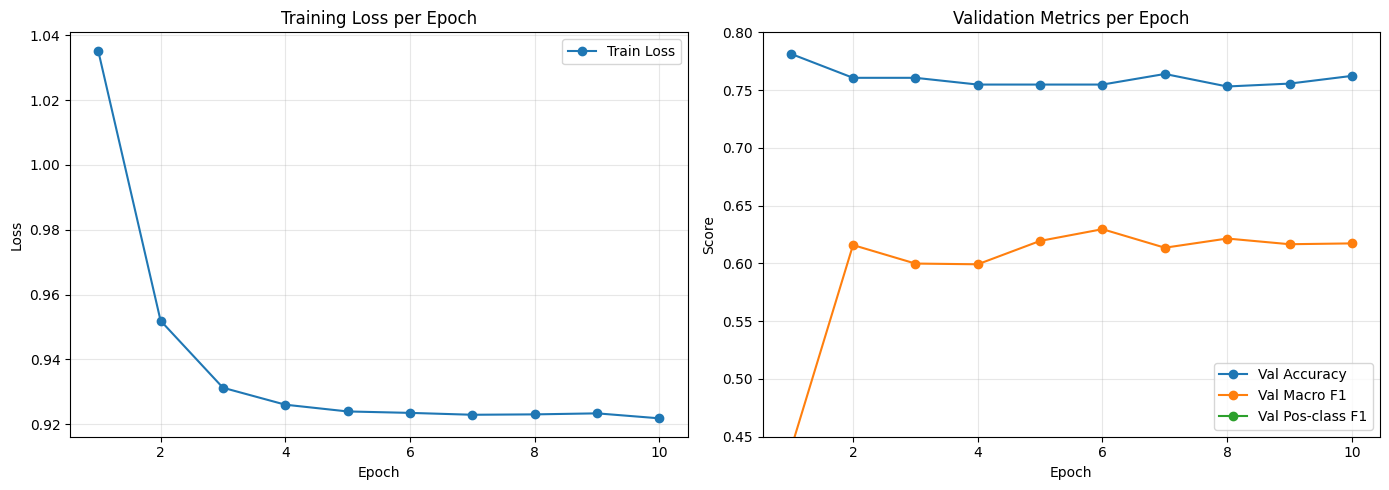

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

training_history_df = pd.DataFrame(training_history)
history_csv_path = f"final_project_data/training_history_K{K}.csv"
training_history_df.to_csv(history_csv_path, index=False)

print(f"Training history saved to {history_csv_path}")
display(training_history_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(training_history_df["epoch"], training_history_df["train_loss"], marker='o', label='Train Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(training_history_df["epoch"], training_history_df["val_accuracy"], marker='o', label='Val Accuracy')
ax2.plot(training_history_df["epoch"], training_history_df["val_macro_f1"], marker='o', label='Val Macro F1')
ax2.plot(training_history_df["epoch"], training_history_df["val_pos_f1"], marker='o', label='Val Pos-class F1')
ax2.set_title('Validation Metrics per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.set_ylim(0.45, 0.8)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()



In [135]:
print("\n========== FINAL TEST EVAL ==========")
eval_model(model, test_loader, device, split_name="TEST")



========== FINAL TEST EVAL ==========

=== TEST ===
              precision    recall  f1-score   support

         0.0      0.816     0.883     0.848      2310
         1.0      0.481     0.352     0.407       710

    accuracy                          0.758      3020
   macro avg      0.648     0.618     0.627      3020
weighted avg      0.737     0.758     0.744      3020

Accuracy: 0.7582781456953642
Macro F1: 0.6273684566367493
Pos-class (SB=1) F1: 0.4065040650406504


(array([1., 1., 1., ..., 0., 0., 0.], shape=(3020,), dtype=float32),
 array([0.37302393, 0.5315331 , 0.6205099 , ..., 0.07375167, 0.17863202,
        0.11010224], shape=(3020,), dtype=float32),
 array([0, 0, 0, ..., 0, 0, 0], shape=(3020,)),
 {'accuracy': 0.7582781456953642,
  'macro_f1': 0.6273684566367493,
  'pos_f1': 0.4065040650406504})


--- Evaluating saved model: K=0 (best_grusb_model_K0.pth) ---
build_sequence_data: X.shape = (3020, 1, 14)  y.mean(SB=1 rate) = 0.23509933

=== TEST (K=0) ===
              precision    recall  f1-score   support

         0.0      0.816     0.883     0.848      2310
         1.0      0.481     0.352     0.407       710

    accuracy                          0.758      3020
   macro avg      0.648     0.618     0.627      3020
weighted avg      0.737     0.758     0.744      3020

Accuracy: 0.7582781456953642
Macro F1: 0.6273684566367493
Pos-class (SB=1) F1: 0.4065040650406504

--- Evaluating saved model: K=1 (best_grusb_model_K1.pth) ---
build_sequence_data: X.shape = (3020, 2, 14)  y.mean(SB=1 rate) = 0.23509933

=== TEST (K=1) ===
              precision    recall  f1-score   support

         0.0      0.823     0.900     0.860      2310
         1.0      0.533     0.372     0.438       710

    accuracy                          0.776      3020
   macro avg      0.678     0.636    

,K,accuracy,macro_f1,pos_f1
0,0,0.758278,0.627368,0.406504
1,1,0.775828,0.649077,0.438174
2,2,0.777815,0.665298,0.471237
3,3,0.777483,0.673555,0.489362
4,4,0.773179,0.673784,0.493718
5,5,0.777815,0.674219,0.490509
6,6,0.774503,0.682290,0.511127
7,7,0.776490,0.670832,0.484339
8,8,0.774834,0.679350,0.504373


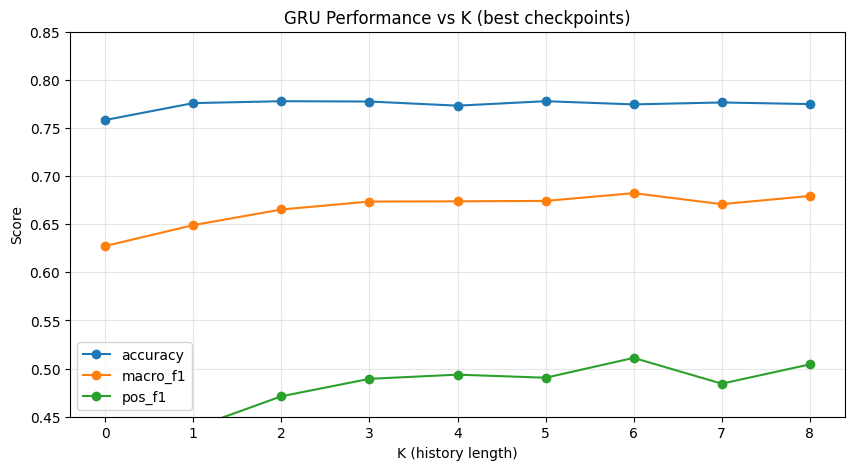

In [137]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 载入持久化的 test split（如不存在则报错）
test_split_path = "final_project_data/test_split.csv"
if not os.path.exists(test_split_path):
    raise FileNotFoundError(f"Saved test split not found at {test_split_path}. Run the split-saving cell first.")

test_df_saved = pd.read_csv(test_split_path)
# 重新计算 turn_id_norm，确保与训练阶段一致
test_df_saved["turn_id_norm"] = test_df_saved.groupby("conv_id")["turn_id"].transform(
    lambda x: x / x.max() if x.max() > 0 else 0
)

def evaluate_saved_models(k_values, test_df_source, batch_size=64, hidden_dim=32, threshold=0.7):
    results = []

    for k in k_values:
        model_path = f"best_grusb_model_K{k}.pth"
        print(f"\n--- Evaluating saved model: K={k} ({model_path}) ---")
        if not os.path.exists(model_path):
            print(f"[SKIP] Checkpoint not found: {model_path}")
            continue

        # 为该 K 构建测试数据（基于持久化的 test split）
        X_test_k, y_test_k = build_sequence_data(test_df_source.copy(), K=k)
        test_loader_k = DataLoader(SBSeqDataset(X_test_k, y_test_k), batch_size=batch_size)

        # 创建模型并加载权重
        model_k = GRUSBModel(input_dim=X_test_k.shape[2], hidden_dim=hidden_dim).to(device)
        state_dict = torch.load(model_path, map_location=device)
        model_k.load_state_dict(state_dict)

        # 在测试集上评估
        _, _, _, metrics = eval_model(
            model_k,
            test_loader_k,
            device,
            split_name=f"TEST (K={k})",
            threshold=threshold,
        )

        results.append({
            "K": k,
            "accuracy": metrics["accuracy"],
            "macro_f1": metrics["macro_f1"],
            "pos_f1": metrics["pos_f1"],
        })

    return pd.DataFrame(results).sort_values("K").reset_index(drop=True)


k_range = list(range(0, 9))  # K=1..8
eval_batch_size = 64
gru_eval_df = evaluate_saved_models(
    k_range,
    test_df_source=test_df_saved,
    batch_size=eval_batch_size,
    hidden_dim=32,
    threshold=0.7,
)

if not gru_eval_df.empty:
    csv_path = "final_project_data/gru_eval_across_K.csv"
    gru_eval_df.to_csv(csv_path, index=False)
    print(f"\nSaved evaluation summary to {csv_path}")
    display(gru_eval_df)

    plt.figure(figsize=(10, 5))
    for metric in ["accuracy", "macro_f1", "pos_f1"]:
        plt.plot(gru_eval_df["K"], gru_eval_df[metric], marker='o', label=metric)
    plt.title("GRU Performance vs K (best checkpoints)")
    plt.xlabel("K (history length)")
    plt.ylabel("Score")
    plt.ylim(0.45, 0.85)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("No saved checkpoints were evaluated. Please ensure best_grusb_model_K*.pth files exist.")
